# RHEL AI / OpenShift AI — Quick Win Demo

## Fuel Efficiency Prediction for Car Carrier (Cegonha) Trucks
This notebook trains a simple regression model to predict **fuel consumption (L/100km)** based on historical trip telemetry.
Use it in **OpenShift AI** (Jupyter) and then export the model for serving via **KServe**.


In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import joblib
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("sample_trips.csv")
df.head()


,trip_id,date,truck_id,num_cars,load_weight_kg,route_distance_km,avg_speed_kmh,elevation_gain_m,ambient_temp_c,rain_mm,wind_kmh,fuel_liters
0,1,2024-04-12,T029,7,9187,991.2,70.9,117,16.9,4.2,9.5,265.69
1,2,2024-06-06,T038,8,12482,652.8,69.0,309,12.2,16.4,20.9,189.47
2,3,2024-05-14,T021,5,6989,666.2,70.3,341,18.0,4.6,7.3,190.16
3,4,2024-02-04,T014,3,4017,855.3,75.9,1,6.6,10.5,5.7,236.25
4,5,2024-07-24,T023,7,9859,665.0,100.0,617,24.8,1.3,14.5,177.38


### Feature Engineering & Target

In [2]:

# Target: fuel consumption per 100km
df = df.copy()
df['fuel_l_per_100km'] = (df['fuel_liters'] / df['route_distance_km']) * 100

features = [
    'num_cars','load_weight_kg','route_distance_km','avg_speed_kmh',
    'elevation_gain_m','ambient_temp_c','rain_mm','wind_kmh'
]
target = 'fuel_l_per_100km'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

rf = RandomForestRegressor(n_estimators=300, random_state=7, n_jobs=-1)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

mae, r2


(1.433846312827694, 0.04756744418727943)

### Feature Importance

In [3]:

importances = rf.feature_importances_
fi = pd.Series(importances, index=features).sort_values(ascending=False)
fi


ambient_temp_c       0.157628
route_distance_km    0.146264
elevation_gain_m     0.143586
avg_speed_kmh        0.141455
load_weight_kg       0.137948
rain_mm              0.124110
wind_kmh             0.117785
num_cars             0.031224
dtype: float64

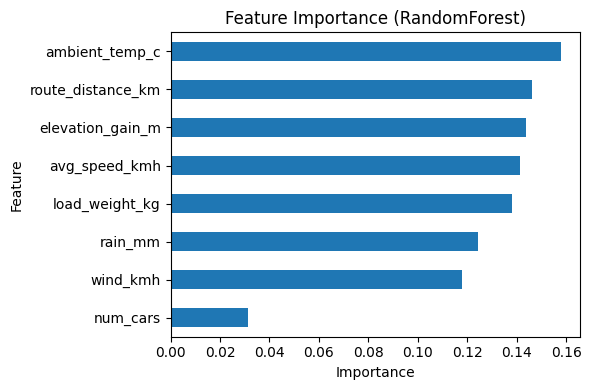

In [4]:

# Plot importance
plt.figure(figsize=(6,4))
fi.sort_values().plot(kind='barh')
plt.title("Feature Importance (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Save Model

In [ ]:

# save model artifact
joblib.dump(rf, "model_random_forest.joblib")
print("Saved model to model_random_forest.joblib")

# save ONNX model
initial_type = [('float_input', FloatTensorType([None, len(features)]))]
onnx_model = convert_sklearn(rf, initial_types=initial_type)
with open("model_random_forest.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
print("Saved ONNX model to model_random_forest.onnx")


Saved model to model_random_forest.joblib


### Try a What-if Scenario (Planned Trip)

In [6]:

planned_trip = pd.DataFrame([{
    'num_cars': 7,
    'load_weight_kg': 7 * 1450,  # 7 cars ~1450kg each
    'route_distance_km': 680,
    'avg_speed_kmh': 78,
    'elevation_gain_m': 550,
    'ambient_temp_c': 26,
    'rain_mm': 3.0,
    'wind_kmh': 12
}])
pred = rf.predict(planned_trip)[0]
print(f"Predicted consumption: {pred:.2f} L/100km, estimated total fuel: {pred * planned_trip['route_distance_km'][0] / 100:.1f} L")


Predicted consumption: 27.94 L/100km, estimated total fuel: 190.0 L
